# Reference
+ [pkl文件与pickle.dump，pickle.load](https://blog.csdn.net/weixin_43135178/article/details/116430144)

In [52]:
import fastai
print("fastai:", fastai.__version__)

from platform import python_version
print("python_version:", python_version())

import torch
print("torch version:", torch.__version__)

fastai: 2.7.10
python_version: 3.7.9
torch version: 1.13.0+cpu


## Install Package

In [53]:
import fastbook
fastbook.setup_book()

from fastai.vision.all import *
from fastai.vision.widgets import *

import pandas as pd
import joblib
import numpy as np
import cv2

## Pre-preparation

In [54]:
labels = pd.read_csv('./image.csv') # 讀取csv
labels['label'].value_counts() # 查看總標籤數量

BLACK        1100
BLUE          906
GRAY          851
WHITE         639
ORANGE        238
RED           230
PINK          117
GREEN         107
PURPLE         70
CYAN           58
YELLOW         54
Undefined      41
Name: color, dtype: int64

In [55]:
#  刪除指定資料
labels = labels.drop(labels[labels['label'] == 'Undefined'].index)

In [56]:
def get_x(r): return './images_original/' + r['label'] + "/" + r['name'] # create path to open images in the original folder
def get_y(r): return r['label'].split(' ') # split the labels using space as a delimitter

# Replace 'Not sure' with 'Not_sure'.
labels.loc[labels['label']=='Not sure','label'] = 'Not_sure'

# Add suffix '.jpg' to all image files in the dataframe to open them within the model.
labels['name'] = labels['name'] + '.jpg' 

# Keep only the images and their labels for the model to process.
label_df = labels[['name', 'color', 'label']]


# 去除重複職
label_df = label_df.dropna(axis=0, how='any')
label_df

,name,color,label
0,T-Shirt_1.jpg,BLACK,T-Shirt
1,T-Shirt_2.jpg,WHITE,T-Shirt
2,T-Shirt_3.jpg,BLACK,T-Shirt
3,T-Shirt_4.jpg,BLUE,T-Shirt
4,T-Shirt_5.jpg,GREEN,T-Shirt
...,...,...,...
4406,Shorts_438.jpg,WHITE,Shorts
4407,Shorts_439.jpg,ORANGE,Shorts
4408,Shorts_440.jpg,ORANGE,Shorts
4409,Shorts_441.jpg,ORANGE,Shorts


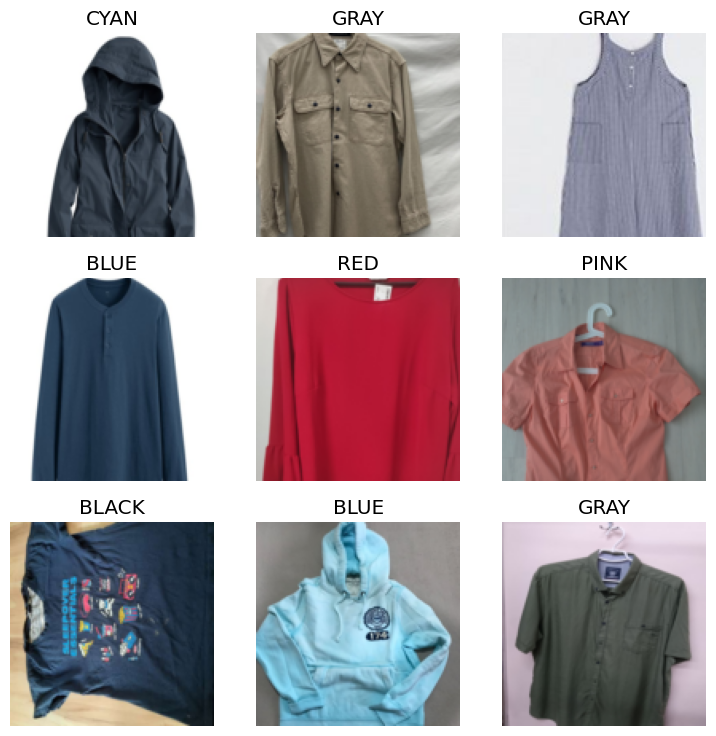

In [57]:
# Create DataBlock
dblock = DataBlock( blocks = (ImageBlock, MultiCategoryBlock),
                    get_x = get_x, get_y = get_y,
                    item_tfms = RandomResizedCrop(128, min_scale=0.35))  # ensure every item is of the same size

dls = dblock.dataloaders(label_df) # collates items from dataset into minibatches

dls.show_batch(nrows=3, ncols=3)

In [58]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context # 通過導入ssl模組改成不用驗證

learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3)

c:\Users\azrxxxc\AppData\Local\Programs\Python\Python37\lib\site-packages\fastai\vision\learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
c:\Users\azrxxxc\AppData\Local\Programs\Python\Python37\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\Users\azrxxxc\AppData\Local\Programs\Python\Python37\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` 

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.816915,0.440427,0.405554,03:37


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.412706,0.214060,0.830144,04:37
1,0.252497,0.133359,0.938631,04:50
2,0.176709,0.131025,0.942168,04:37


In [59]:
# Get Predictions and target variables
preds,targs = learn.get_preds()

In [60]:
learn.fit_one_cycle(1,1e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.146206,0.119456,0.951217,04:37


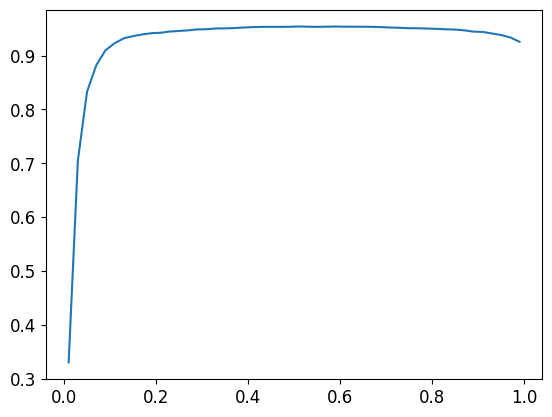

In [61]:
xs = torch.linspace(0.01,0.99,50)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs] # get_preds applies sigmoid activation function

plt.plot(xs,accs);

In [62]:
# learn.export(Path("./export.pkl"))
joblib.dump(learn,'joblib_export.pkl')

['joblib_export.pkl']

In [63]:
clf2 = joblib.load('joblib_export.pkl')

In [64]:
clf2.summary()  

Sequential (Input shape: 64 x 3 x 128 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 64 x 64   
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 32 x 32   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      

In [65]:
type(clf2)

fastai.learner.Learner

In [66]:
def ClassifierLoop(predict):
    label_list = predict[0]
    tensorBase = predict[2]
    
    tens_list = []
    for base in tensorBase:
        if base.item() > 0.5:
            tens_list.append(base.item())
        
    print(tens_list, label_list)
    print(label_list[np.argmax(tens_list)])
    
    return label_list[np.argmax(tens_list)]

In [70]:
# 讀取圖檔
clf_ori = joblib.load('joblib_export.pkl')
# clf_aft = joblib.load('joblib_export_aft.pkl')

img = cv2.imread('./real_case_picture/4_T-Shirt.jpg')
image = cv2.resize(img, (480, 600))

print(clf_ori.predict(img))
print("-------------------------------------")

(['BLUE'], TensorBase([False,  True, False, False, False, False, False, False, False, False, False]), TensorBase([0.0159, 0.9945, 0.0212, 0.0038, 0.0041, 0.0050, 0.0130, 0.0295, 0.0120, 0.0116, 0.0067]))
-------------------------------------
